##Dataset properties##

Total number of images: 82213.

Training set size: 61488 images (one fruit or vegetable per image).

Test set size: 20622 images (one fruit or vegetable per image).

Multi-fruits set size: 103 images (more than one fruit (or fruit class) per image)

Number of classes: 120 (fruits and vegetables).

Image size: 100x100 pixels.

Filename format: image_index_100.jpg (e.g. 32_100.jpg) or r_image_index_100.jpg (e.g. r_32_100.jpg) or r2_image_index_100.jpg or r3_image_index_100.jpg. "r" stands for rotated fruit. "r2" means that the fruit was rotated around the 3rd axis. "100" comes from image size (100x100 pixels).

Different varieties of the same fruit (apple for instance) are stored as belonging to different classes.

## Fruits 360 with Transfer Learning ##

#### Loading the Data Set ####

In [0]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset.git
!ls
!cd Fruit-Images-Dataset
!ls

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 377165, done.
remote: Total 377165 (delta 0), reused 0 (delta 0), pack-reused 377165
Receiving objects: 100% (377165/377165), 2.06 GiB | 38.91 MiB/s, done.
Resolving deltas: 100% (1160/1160), done.
Checking out files: 100% (82231/82231), done.
Fruit-Images-Dataset  sample_data
Fruit-Images-Dataset  sample_data


#### Checking ImageNet Pretrained Models ####

In [0]:
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,BatchNormalization,Flatten,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import glob
import os

# imports for array-handling and plotting
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})


from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
def metrics_plot(history):
  # plotting the metrics
  fig = plt.figure()
  plt.subplot(2,1,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  pyplot.title('Classification Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='lower right')

  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  pyplot.title('Cross Entropy Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

  return fig

def eval_model(model):
  score = model.evaluate(X_test, Y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1]*100) 

import matplotlib.pyplot as plt
def compare_plot(model_hist1, model_hist2):
  # plotting the metrics
  fig = plt.figure()
  plt.subplot(2,1,1)
  # summarize history for accuracy
  plt.plot(model_hist1.history['val_accuracy'])
  plt.plot(model_hist2.history['val_accuracy'])
  plt.title('Classification Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Pretrained', 'W/outTransferLearning'], loc='upper left')

  plt.subplot(2,1,2)
  # summarize history for loss
  plt.plot(model_hist1.history['val_loss'])
  plt.plot(model_hist2.history['val_loss'])
  plt.title('Cross Entropy Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Pretrained', 'W/outTransferLearning'], loc='upper left')
  
  return fig

#### Image Preprocessing ####

In [0]:
nb_train_samples=61488
nb_validation_samples=20622

In [0]:
from keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(64, 64),
        batch_size=200)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=200, shuffle=False,)

Using TensorFlow backend.


Found 61488 images belonging to 120 classes.
Found 20622 images belonging to 120 classes.


## CNN Models ##

#### Without Transfer Learning ####

In [0]:
# Make Convolutional Neural Network

def my_model2():
  model=Sequential()
  model.add(Conv2D(16,(5,5),input_shape=(64,64,3),activation='relu'))
  model.add(Conv2D(32,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=2))
  model.add(BatchNormalization())
  model.add(Conv2D(64,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=2))
  model.add(BatchNormalization())
  model.add(Conv2D(128,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=2))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(120,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam',
                metrics=['accuracy'])
  model.summary()

  return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 60, 60, 16)        1216      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 32)        12832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 64)       

In [0]:
cnn_model_2 = my_model2()

In [0]:
# Compile and fit
cnn_model_2_history = cnn_model_2.fit(X_train,
          Y_train,
          batch_size=200,
          epochs=10,
          verbose=1,
          validation_data = (X_test,Y_test)
         )

Epoch 1/10
308/308 [==============================] - 9s 28ms/step - loss: 0.6374 - accuracy: 0.8286 - val_loss: 6.7502 - val_accuracy: 0.2016
Epoch 2/10
308/308 [==============================] - 8s 27ms/step - loss: 0.0832 - accuracy: 0.9734 - val_loss: 0.4361 - val_accuracy: 0.8924
Epoch 3/10
308/308 [==============================] - 9s 29ms/step - loss: 0.0449 - accuracy: 0.9856 - val_loss: 0.3655 - val_accuracy: 0.9127
Epoch 4/10
308/308 [==============================] - 9s 29ms/step - loss: 0.0457 - accuracy: 0.9868 - val_loss: 0.5237 - val_accuracy: 0.9022
Epoch 5/10
308/308 [==============================] - 12s 40ms/step - loss: 0.0281 - accuracy: 0.9922 - val_loss: 0.2913 - val_accuracy: 0.9304
Epoch 6/10
308/308 [==============================] - 8s 27ms/step - loss: 0.0436 - accuracy: 0.9873 - val_loss: 0.4749 - val_accuracy: 0.9086
Epoch 7/10
308/308 [==============================] - 8s 27ms/step - loss: 0.0294 - accuracy: 0.9919 - val_loss: 0.1241 - val_accuracy: 0.974

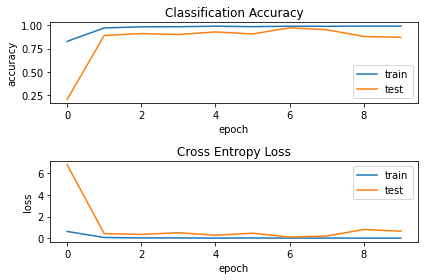

In [0]:
metrics_plot(cnn_model_2_history)

In [0]:
result = vgg_model.evaluate_generator(validation_generator, 
                                      steps=int(nb_train_samples / 64))
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 96.52%


In [0]:
# Setting Image Directories for Training, Validation and Testing Multiple Fruits
train_dir='Fruit-Images-Dataset/Training/'
validation_dir='Fruit-Images-Dataset/Test/'
testPred_dir='Fruit-Images-Dataset/test-multiple_fruits/'

In [0]:
nb_train_samples=61488
nb_validation_samples=20622

#### VGG16 ####

In [0]:
# importing the libraries
from tensorflow.keras.applications.vgg16 import VGG16
IMAGE_SIZE = [64, 64]  
vgg = VGG16(input_shape=(64,64,3), 
            weights = 'imagenet', include_top = False) 

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [0]:
from keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(64, 64),
        batch_size=200)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=200, shuffle=False,)

Using TensorFlow backend.


Found 61488 images belonging to 120 classes.
Found 20622 images belonging to 120 classes.


In [0]:
vgg_model = Sequential()
vgg_model.add(vgg)
vgg_model.add(Flatten())
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dense(120, activation='softmax'))
vgg_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_12 (Dense)             (None, 120)               30840     
Total params: 15,270,072
Trainable params: 15,270,072
Non-trainable params: 0
_________________________________________________________________


In [0]:
vgg_history1 = vgg_model.fit_generator(train_generator,
                   steps_per_epoch = int(nb_train_samples / 64),  # this should be equal to total number of images in training set. But to speed up the execution, I am only using 10000 images. Change this for better results. 
                   epochs = 10,  # change this for better results
                   validation_data = validation_generator,
                   validation_steps = int(nb_validation_samples / 64),
                   verbose = 1)  # this should be equal to total number of images in validation set.

Epoch 1/10
960/960 [==============================] - 384s 400ms/step - loss: 1.7171 - accuracy: 0.5083 - val_loss: 0.5125 - val_accuracy: 0.8259
Epoch 2/10
960/960 [==============================] - 380s 395ms/step - loss: 0.2867 - accuracy: 0.9029 - val_loss: 0.1456 - val_accuracy: 0.9497
Epoch 3/10
960/960 [==============================] - 376s 392ms/step - loss: 0.1587 - accuracy: 0.9463 - val_loss: 0.1173 - val_accuracy: 0.9609
Epoch 4/10
960/960 [==============================] - 380s 395ms/step - loss: 0.1192 - accuracy: 0.9600 - val_loss: 0.1058 - val_accuracy: 0.9646
Epoch 5/10
960/960 [==============================] - 379s 395ms/step - loss: 0.1055 - accuracy: 0.9651 - val_loss: 0.1600 - val_accuracy: 0.9551
Epoch 6/10
960/960 [==============================] - 381s 397ms/step - loss: 0.1005 - accuracy: 0.9674 - val_loss: 0.2178 - val_accuracy: 0.9354
Epoch 7/10
960/960 [==============================] - 382s 398ms/step - loss: 0.0774 - accuracy: 0.9748 - val_loss: 0.1606 -

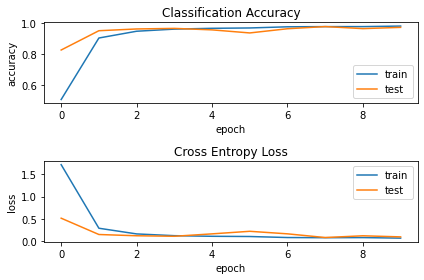

In [0]:
metrics_plot(vgg_history1)

In [0]:
result = vgg_model.evaluate_generator(validation_generator, steps=1288)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 97.22%


#### INCEPTIONV3 ####

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

IMAGE_SIZE = [299, 299] 
inceptionv3 = InceptionV3(input_shape=(299,299,3),
                          weights = 'imagenet', include_top = False) 

In [0]:
from keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(299, 299),
        batch_size=32)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=32, shuffle=False,)

Found 61488 images belonging to 120 classes.
Found 20622 images belonging to 120 classes.


In [0]:
inceptionv3_model = Sequential()
inceptionv3_model.add(inceptionv3)
inceptionv3_model.add(GlobalAveragePooling2D())
inceptionv3_model.add(Dense(512, activation='relu'))
inceptionv3_model.add(Dense(120, activation='softmax'))
inceptionv3_model.compile(loss='categorical_crossentropy',
                          optimizer='adam',metrics=['accuracy'])
inceptionv3_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_62 (Dense)             (None, 120)               61560     
Total params: 22,913,432
Trainable params: 22,879,000
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
inceptionv3_history = inceptionv3_model.fit_generator(train_generator,
                   steps_per_epoch = int(nb_train_samples / 64),  # this should be equal to total number of images in training set. But to speed up the execution, I am only using 10000 images. Change this for better results. 
                   epochs = 10,  # change this for better results
                   validation_data = validation_generator,
                   validation_steps = int(nb_validation_samples / 64),
                   verbose = 1)  # this should be equal to total number of images in validation set.

Epoch 1/10
960/960 [==============================] - 625s 651ms/step - loss: 1.0183 - accuracy: 0.7132 - val_loss: 0.6045 - val_accuracy: 0.8155
Epoch 2/10
960/960 [==============================] - 619s 645ms/step - loss: 0.1974 - accuracy: 0.9374 - val_loss: 0.2756 - val_accuracy: 0.9321
Epoch 3/10
960/960 [==============================] - 619s 645ms/step - loss: 0.1265 - accuracy: 0.9597 - val_loss: 0.0847 - val_accuracy: 0.9757
Epoch 4/10
960/960 [==============================] - 624s 650ms/step - loss: 0.0999 - accuracy: 0.9694 - val_loss: 0.1647 - val_accuracy: 0.9569
Epoch 5/10
960/960 [==============================] - 618s 643ms/step - loss: 0.0897 - accuracy: 0.9718 - val_loss: 0.0419 - val_accuracy: 0.9824
Epoch 6/10
960/960 [==============================] - 610s 636ms/step - loss: 0.0816 - accuracy: 0.9756 - val_loss: 0.3712 - val_accuracy: 0.9016
Epoch 7/10
960/960 [==============================] - 611s 637ms/step - loss: 0.0607 - accuracy: 0.9814 - val_loss: 0.0396 -

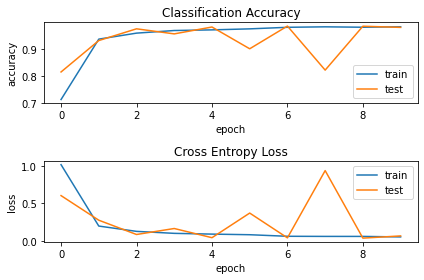

In [0]:
metrics_plot(inceptionv3_history)

In [0]:
result = inceptionv3_model.evaluate_generator(validation_generator, steps=1288)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test-set classification accuracy: 98.34%


#### XCEPTION ####

In [0]:
from tensorflow.keras.applications.xception import Xception, preprocess_input

IMAGE_SIZE = [299, 299] 
xception_base = Xception(input_shape = (299,299,3), 
                         weights = 'imagenet', include_top = False) 

In [0]:
xception_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(299, 299),
        batch_size=16,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=16, shuffle=False,class_mode='categorical')

Found 61488 images belonging to 120 classes.
Found 20622 images belonging to 120 classes.


In [0]:
xception_model = Sequential()
xception_model.add(xception_base)
xception_model.add(GlobalAveragePooling2D())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(120, activation='softmax'))
xception_model.compile(loss='categorical_crossentropy',
                       optimizer='adam',metrics=['accuracy'])
xception_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_10 (Dense)             (None, 120)               61560     
Total params: 21,972,128
Trainable params: 21,917,600
Non-trainable params: 54,528
_________________________________________________________________


In [0]:
xception_history = xception_model.fit_generator(train_generator,
                   steps_per_epoch = int(nb_train_samples / 64),  
                   epochs = 10,  # change this for better results
                   validation_data = validation_generator,
                   validation_steps = int(nb_validation_samples / 64),
                   verbose = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
960/960 [==============================] - 379s 395ms/step - loss: 0.9349 - accuracy: 0.7504 - val_loss: 0.5057 - val_accuracy: 0.8513
Epoch 2/10
960/960 [==============================] - 378s 394ms/step - loss: 0.1613 - accuracy: 0.9504 - val_loss: 0.3339 - val_accuracy: 0.9266
Epoch 3/10
960/960 [==============================] - 378s 394ms/step - loss: 0.1124 - accuracy: 0.9674 - val_loss: 0.1735 - val_accuracy: 0.9561
Epoch 4/10
960/960 [==============================] - 378s 394ms/step - loss: 0.1093 - accuracy: 0.9691 - val_loss: 0.0653 - val_accuracy: 0.9821
Epoch 5/10
960/960 [==============================] - 379s 394ms/step - loss: 0.0756 - accuracy: 0.9786 - val_loss: 0.1298 - val_accuracy: 0.9641
Epoch 6/10
960/960 [==============================] - 378s 393ms/step - loss: 0.0764 - accuracy: 0.9788 - val_loss: 0.2240 - val_accuracy: 0.9596
Epoch 7/10
960/960 [============================

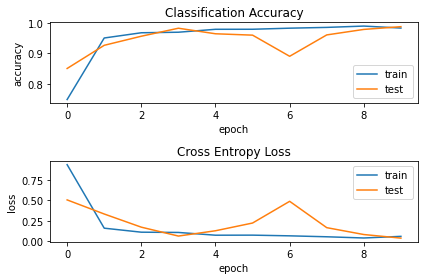

In [0]:
metrics_plot(xception_history)

In [0]:
result = xception_model.evaluate_generator(validation_generator, steps=1288)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 98.01%
